<a href="https://colab.research.google.com/github/umbertogriffo/kaggle-ranzcr-catheter-and-line-position-challenge-baseline/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kill -9 -1

# Install Kaggle API

In [ ]:
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle # force install the latest version

     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp37-none-any.whl size=73269 sha256=e5218c04684d2ed86dd63553240c7bb94fd7a870ce46a89b2c0cbc634c3c8027
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


# API Credentials

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/username/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. 

Place this file on your Google Drive anywhere.

With the next snippet you download your credentials to Colab and you can start using Kaggle API

In [ ]:
# Install gcloud python module and google-api-python-client module
!pip install --upgrade gcloud
!pip install --upgrade google-api-python-client

     |████████████████████████████████| 460kB 6.0MB/s 
  Created wheel for gcloud: filename=gcloud-0.18.3-cp37-none-any.whl size=602938 sha256=8acb39ef4f8ac95b72195afd418f83978542fd6c957c4957af63996c55e5e614
  Stored in directory: /root/.cache/pip/wheels/b9/9b/9c/a01be401658fea33b93a35d03921b0c638266821b264dc8662
Successfully built gcloud
     |████████████████████████████████| 6.5MB 6.7MB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
  Found existing installation: google-api-core 1.16.0
    Uninstalling google-api-core-1.16.0:
      Successfully uninstalled google-api-core-1.16.0
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

# Download The Dataset From Kaggle

In [ ]:
!kaggle competitions download -c ranzcr-clip-catheter-line-classification -p /content/
!unzip -q /content/ranzcr-clip-catheter-line-classification.zip
!rm /content/ranzcr-clip-catheter-line-classification.zip

100% 11.7G/11.7G [03:09<00:00, 52.9MB/s]
100% 11.7G/11.7G [03:09<00:00, 66.3MB/s]


In [ ]:
%cd /content
!ls

/content
adc.json	       test	       train_annotations.csv
sample_data	       test_tfrecords  train.csv
sample_submission.csv  train	       train_tfrecords


# Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import os

# This address identifies the TPU we'll use when configuring TensorFlow.
# TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

def auto_select_accelerator(tpu_worker_address=None):
    try:
        # tf.config.experimental_connect_to_host(tpu_worker_address)
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_worker_address) # TPU detection
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        print('Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy

strategy = auto_select_accelerator()

Tensorflow version 2.4.1
INFO:tensorflow:Initializing the TPU system: grpc://10.92.21.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.92.21.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU: grpc://10.92.21.58:8470
Running on 8 replicas


In [ ]:
# Listing Devices
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15866360561727782224, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17166789748461145350
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
# Testing for GPU
tf.test.gpu_device_name()

'/device:GPU:0'

# Import libraries

In [ ]:
# http://scikit.ml/stratification.html
# http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html#skmultilearn.model_selection.iterative_stratification.iterative_train_test_split
!pip install scikit-multilearn
!pip install arff
# https://www.tensorflow.org/addons
!pip install tensorflow-addons

In [ ]:
import numpy as np
import pandas as pd

import gc
import os
from glob import glob
from random import shuffle
import cv2
import datetime
import matplotlib.pyplot as plt

from albumentations import Compose, RandomRotate90, Transpose, Flip, OneOf, CLAHE, IAASharpen, IAAEmboss, RandomBrightnessContrast, JpegCompression, Blur, GaussNoise, HueSaturationValue, ShiftScaleRotate, Normalize

from sklearn.model_selection import train_test_split, KFold
from skmultilearn.model_selection import iterative_train_test_split, IterativeStratification

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Model
from tensorflow.keras.applications import Xception, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, ResNet152V2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

For reproducibility:

In [ ]:
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Functions

## Build Dataset

In [ ]:
def build_decoder(target_size, with_labels=True, ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path) # Reads and outputs the entire contents of the input filename.

        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3) # Decode a PNG-encoded image to a uint8 or uint16 tensor
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3) # Decode a JPEG-encoded image to a uint8 tensor
        else:
            raise ValueError("Image extension not supported")

        img = tf.cast(img, tf.float32) / 255.0 # Casts a tensor to the type float32 and divides by 255.
        img = tf.image.resize(img, target_size) # Resizing to target size
        return img
    
    def decode_with_labels(path, label):
        return decode(path), tf.dtypes.cast(label, tf.float32)
    
    return decode_with_labels if with_labels else decode

def build_augmenter(with_labels=True):
  def augment(img):
      img = tf.image.random_flip_left_right(img)
      img = tf.image.random_flip_up_down(img)
      img = tf.image.random_saturation(img, 0.8, 1.2)
      img = tf.image.random_brightness(img, 0.2)
      img = tf.image.random_contrast(img, 0.8, 1.2)
      img = tf.image.random_hue(img, 0.2)
      return img
  
  def augment_with_labels(img, label):
      return augment(img), label
  
  return augment_with_labels if with_labels else augment

def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO) # overlaps data preprocessing and model execution while training
    return dset

def build_tta(paths, bsize=32, decode_fn = None, augment_fn = None, tta = False):
  
  AUTO = tf.data.experimental.AUTOTUNE
  dset = tf.data.Dataset.from_tensor_slices(paths)
  dset = dset.map(decode_fn, num_parallel_calls = AUTO)
  dset = dset.map(augment_fn, num_parallel_calls = AUTO)
  if tta:
    dset = dset.repeat() 
  dset = dset.batch(bsize)
  dset = dset.prefetch(AUTO)
  return dset

## Model

In [ ]:
def get_model(architecture, img_size, n_classes):
  if architecture == "Xception":
    net = Xception(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  elif architecture == "ResNet152V2":
    net = ResNet152V2(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  elif architecture == "EfficientNetB0":
    net = EfficientNetB0(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  elif architecture == "EfficientNetB1":
    net = EfficientNetB1(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  elif architecture == "EfficientNetB2":
    net = EfficientNetB2(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  elif architecture == "EfficientNetB3":
    net = EfficientNetB3(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  elif architecture == "EfficientNetB4":
    net = EfficientNetB4(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  elif architecture == "EfficientNetB5":
    net = EfficientNetB5(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  elif architecture == "EfficientNetB6":
    net = EfficientNetB6(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  elif architecture == "EfficientNetB7":
    net = EfficientNetB7(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
  else:
     raise BaseException(f"The architecture {architecture} is not supported.")
  x = net.output
  x = GlobalAveragePooling2D()(x)
  output = Dense(n_classes, activation='sigmoid')(x)
  model = Model(inputs=net.input, outputs=output)

  return model

def get_callbacks(model_path, lrfn):

  callbacks = []

  callbacks.append(TerminateOnNaN())

  callbacks.append(EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1,
        restore_best_weights=True))

  callbacks.append(ModelCheckpoint(
        model_path,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'))

  callbacks.append(ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.8, 
        patience=2, 
        verbose=1, 
        mode='auto', 
        epsilon=0.0001, 
        cooldown=5, 
        min_lr=0.00001))
  
  if lrfn is not None:
    callbacks.append(LearningRateScheduler(
          lambda epoch: lrfn(epoch), 
          verbose=True))

  return callbacks

## Utils

In [ ]:
def plot_metric(history_in, metric_name, results_dir):
    """
    Plot a metric of model's history.
    """

    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history_in.history[metric_name])
    plt.plot(history_in.history['val_' + metric_name])

    plt.title('model ' + metric_name)
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    fig_acc.savefig(os.path.join(results_dir, "model_" + metric_name + ".png"))

    plt.cla()
    plt.close()


def mkdir_if_not_exist(directory):

        if not os.path.exists(directory):
            try:
                os.makedirs(directory)
            except OSError as e:
                print("Error: %s - %s." % (e.filename, e.strerror))

# Data Preparation

In [ ]:
GCS_DS_PATH = "gs://kds-8fdde4eb643ffca87f4d2e302b48cea859367cad0b9a6e98d65c407a"

In [ ]:
df = pd.read_csv("/content/train.csv")
print(f"{df.columns}")
print(len(df), df['StudyInstanceUID'].nunique())
print('Number of Records:',len(df), 'Number of Patients:' ,df['PatientID'].nunique())

Index(['StudyInstanceUID', 'ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present',
       'PatientID'],
      dtype='object')
30083 30083
Number of Records: 30083 Number of Patients: 3255


In [ ]:
paths = GCS_DS_PATH + "/train/" + df['StudyInstanceUID'] + '.jpg'
paths[0]

'gs://kds-8fdde4eb643ffca87f4d2e302b48cea859367cad0b9a6e98d65c407a/train/1.2.826.0.1.3680043.8.498.26697628953273228189375557799582420561.jpg'

In [ ]:
# Get the multi-labels
df_sub = pd.read_csv("/content/sample_submission.csv")
labels_cols = df_sub.columns[1:]
n_classes = len(labels_cols)
print(f"{n_classes} - {labels_cols}")

11 - Index(['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal',
       'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal',
       'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
       'Swan Ganz Catheter Present'],
      dtype='object')


In [ ]:
labels = df[labels_cols].values
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 1, 0]])

In [ ]:
id_label_map = {k: v for k, v in zip(paths, labels)}

In [ ]:
#@title Configuration
#@markdown 
train_limit = 30083  #@param {type: "number"}
test_limit = 3582  #@param {type: "number"}
img_size =  612#@param {type:"integer"}
batch_size_in =   8#@param {type: "integer", min: 8, max: 128}


## Build train and validation datasets

In [ ]:
ndarr_paths = np.reshape(paths.to_numpy(), (paths.shape[0], 1))
ndarr_paths

array([['gs://kds-8fdde4eb643ffca87f4d2e302b48cea859367cad0b9a6e98d65c407a/train/1.2.826.0.1.3680043.8.498.26697628953273228189375557799582420561.jpg'],
       ['gs://kds-8fdde4eb643ffca87f4d2e302b48cea859367cad0b9a6e98d65c407a/train/1.2.826.0.1.3680043.8.498.46302891597398758759818628675365157729.jpg'],
       ['gs://kds-8fdde4eb643ffca87f4d2e302b48cea859367cad0b9a6e98d65c407a/train/1.2.826.0.1.3680043.8.498.23819260719748494858948050424870692577.jpg'],
       ...,
       ['gs://kds-8fdde4eb643ffca87f4d2e302b48cea859367cad0b9a6e98d65c407a/train/1.2.826.0.1.3680043.8.498.43173270582850645437451931712017243531.jpg'],
       ['gs://kds-8fdde4eb643ffca87f4d2e302b48cea859367cad0b9a6e98d65c407a/train/1.2.826.0.1.3680043.8.498.95092491950130838685690656747242898392.jpg'],
       ['gs://kds-8fdde4eb643ffca87f4d2e302b48cea859367cad0b9a6e98d65c407a/train/1.2.826.0.1.3680043.8.498.99518162226171269731026325462883860316.jpg']],
      dtype=object)

In [ ]:
batch_size = strategy.num_replicas_in_sync * batch_size_in
print(f"Batch size: {batch_size}")

# train_paths, valid_paths, train_labels, valid_labels = train_test_split(paths[0:train_limit], labels[0:train_limit], test_size=0.1, shuffle=True, random_state=SEED)

# Multi-label data stratification
train_paths, train_labels, valid_paths, valid_labels = iterative_train_test_split(ndarr_paths[0:train_limit], labels[0:train_limit], test_size = 0.1)
train_paths = train_paths.flatten()
valid_paths = valid_paths.flatten()

print(f"# Training images: {train_paths.shape}")
print(f"# Training labels: {train_labels.shape}")
print(f"# Validation images: {valid_paths.shape}")
print(f"# Validation labels: {valid_labels.shape}")
print(f"# Training steps: {len(train_paths) // batch_size}")
print(f"# Validation steps: {len(valid_paths) // batch_size}")

Batch size: 64
# Training images: (27066,)
# Training labels: (27066, 11)
# Validation images: (3017,)
# Validation labels: (3017, 11)
# Training steps: 422
# Validation steps: 47


In [ ]:
# Build the tensorflow datasets
decoder = build_decoder(target_size=(img_size, img_size), with_labels=True)

# Build the tensorflow datasets
dtrain = build_dataset(
    train_paths, train_labels, bsize=batch_size, decode_fn=decoder
)

dvalid = build_dataset(
    valid_paths, valid_labels, bsize=batch_size, 
    repeat=False, shuffle=False, augment=False, decode_fn=decoder
)

dtrain

<PrefetchDataset shapes: ((None, 612, 612, 3), (None, 11)), types: (tf.float32, tf.float32)>

# Modeling

In [ ]:
#@title Configuration
#@markdown 
output_path = "model" #@param {type: "string"}
epochs = 30#@param {type:"integer"}
n_fold = 5  #@param {type: "slider", min: 2, max: 10}
architecture = "EfficientNetB5" #@param ["Xception", "ResNet152V2", "EfficientNetB0", "EfficientNetB1", "EfficientNetB2", "EfficientNetB3", "EfficientNetB4", "EfficientNetB5", "EfficientNetB6", "EfficientNetB7"]
use_lr_strategy = False #@param {type:"boolean"}




Calculate and show a learning rate schedule. We start with a fairly low rate, as we're using a pre-trained model and don't want to undo all the fine work put into training it.

Learning rate per epoch:


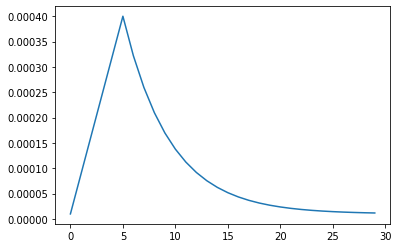

In [ ]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
rang = np.arange(epochs)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

### Single model
To get maxmimum accuracy, we leverage a pretrained image recognition model. We drop the ImageNet-specific top layers (`include_top=false`), and add a max pooling and a softmax layer to predict our 11 classes.
We also use [Focal loss](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy) since we have highly imbalanced classes. It down-weights well-classified examples and focuses on hard examples. The loss value is much high for a sample which is misclassified by the classifier as compared to the loss value corresponding to a well-classified example.

In [ ]:
with strategy.scope():
  model = get_model(architecture, img_size, n_classes)
  model.compile(tf.optimizers.Adam(lr=1e-3),
                loss=tfa.losses.SigmoidFocalCrossEntropy(alpha = 0.50, gamma = 2.0),
                metrics=[tf.keras.metrics.AUC(name="auc", multi_label=True)])

In [ ]:
path = os.path.join("output_path", "single_model")
mkdir_if_not_exist(path)
model_path = os.path.join(path, f"{architecture}_model.h5")

lr_strategy=lrfn if use_lr_strategy else None
callbacks = get_callbacks(model_path, lr_strategy)

with strategy.scope():
  history = model.fit(
          dtrain,
          validation_data=dvalid,
          epochs=epochs, 
          verbose=1,
          callbacks=callbacks,
          steps_per_epoch=len(train_paths) // batch_size,
          validation_steps=len(valid_paths) // batch_size)

  # summarize history
  plot_metric(history, 'loss', path)
  plot_metric(history, 'auc', path)

# To avoid timeout 
print("Avoiding timeout...")
while True:pass

Epoch 1/30
422/422 [==============================] - 1335s 3s/step - loss: 0.4043 - auc: 0.7035 - val_loss: 0.4376 - val_auc: 0.7058

Epoch 00001: val_loss improved from inf to 0.43761, saving model to output_path/single_model/EfficientNetB5_model.h5
Epoch 2/30
422/422 [==============================] - 329s 780ms/step - loss: 0.3475 - auc: 0.7771 - val_loss: 0.4890 - val_auc: 0.5537

Epoch 00002: val_loss did not improve from 0.43761
Epoch 3/30
422/422 [==============================] - 330s 782ms/step - loss: 0.3353 - auc: 0.7966 - val_loss: 0.6460 - val_auc: 0.4986

Epoch 00003: val_loss did not improve from 0.43761

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 4/30
400/422 [===========================>..] - ETA: 16s - loss: 0.3252 - auc: 0.8095

In [ ]:
from google.colab import files
files.download(model_path) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Single model predictions

In [ ]:
with strategy.scope():
    model = tf.keras.models.load_model(model_path)

In [ ]:
test_decoder = build_decoder(with_labels=False, target_size=(img_size, img_size))

df_sub = pd.read_csv("/content/sample_submission.csv")
test_paths = GCS_DS_PATH + "/test/" + df_sub['StudyInstanceUID'] + '.jpg'

dtest = build_dataset(
    test_paths, bsize=batch_size, repeat=False, 
    shuffle=False, augment=False, cache=False, 
    decode_fn=test_decoder
)
dtest

<PrefetchDataset shapes: (None, 768, 768, 3), types: tf.float32>

In [ ]:
y_preds = model.predict(dtest, verbose=1)

448/448 [==============================] - 119s 262ms/step


In [ ]:
df_sub.iloc[:, 1:] = y_preds
display(df_sub)

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0.163448,0.480167,0.503715,0.019151,0.050424,0.107511,0.920570,0.110259,0.283620,0.842426,0.991603
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0.017474,0.017323,0.029714,0.039311,0.024697,0.066573,0.031252,0.060093,0.148542,0.891637,0.004435
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0.013433,0.012706,0.055000,0.143001,0.073421,0.194078,0.068333,0.156495,0.453125,0.488326,0.016742
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0.091283,0.191112,0.229841,0.185928,0.066009,0.814516,0.165254,0.189049,0.333241,0.777059,0.332558
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0.094455,0.078671,0.036008,0.100051,0.065798,0.044584,0.203545,0.071929,0.222991,0.843799,0.013340
...,...,...,...,...,...,...,...,...,...,...,...,...
3577,1.2.826.0.1.3680043.8.498.81464483108873296584...,0.072672,0.123288,0.127274,0.117141,0.067327,0.846071,0.196342,0.116550,0.273004,0.760274,0.187562
3578,1.2.826.0.1.3680043.8.498.33579133018211530710...,0.058521,0.048267,0.051908,0.088657,0.079469,0.047833,0.196794,0.421112,0.461826,0.461826,0.141738
3579,1.2.826.0.1.3680043.8.498.61472811086105902907...,0.027224,0.039311,0.036949,0.035518,0.044070,0.008125,0.065572,0.092413,0.280129,0.760023,0.005993
3580,1.2.826.0.1.3680043.8.498.19434375795525494655...,0.012600,0.018724,0.052611,0.023162,0.044503,0.017956,0.110142,0.211471,0.575033,0.303013,0.018758


In [ ]:
df_sub.to_csv('submission.csv',index=False)

#### TTA
A final technique that can raise accuracy by one percent or two is test time augmentation (TTA). This involves taking a series of different versions of the original image (for example cropping different areas, or changing the zoom) and passing them through the model. The average output is then calculated for the different versions and this is given as the final output score for the image.

In [ ]:
# Test time augmentation rounds
TTA = 5
NUM_TESTING_IMAGES = df_sub.shape[0]
steps = TTA * ((NUM_TESTING_IMAGES / batch_size) + 1)

# Get the test dataset with tta to extract image
tta_dtest = build_tta(test_paths,
                      decode_fn=build_decoder(with_labels=False, 
                                              target_size=(img_size, img_size)),
                      augment_fn=build_augmenter(with_labels=False), 
                      bsize=batch_size, 
                      tta = True)

probabilities = model.predict(tta_dtest, steps = steps, verbose=1)[: TTA * NUM_TESTING_IMAGES]
probabilities = np.mean(probabilities.reshape((NUM_TESTING_IMAGES, TTA, n_classes), order = 'F'), axis = 1)

df_sub.iloc[:, 1:] = probabilities
display(df_sub)

2243/2243 [==============================] - 342s 152ms/step


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0.203044,0.470929,0.502128,0.037043,0.076248,0.096485,0.895558,0.179277,0.334679,0.758563,0.945995
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0.018607,0.018920,0.028016,0.033905,0.018180,0.070100,0.024521,0.080314,0.181349,0.851251,0.006539
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0.015097,0.013354,0.048031,0.109525,0.059120,0.136682,0.063098,0.165148,0.451397,0.492348,0.016332
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0.110147,0.209086,0.265355,0.179103,0.088013,0.803160,0.182418,0.243529,0.334931,0.686372,0.284333
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0.066202,0.059943,0.034095,0.062333,0.048361,0.035568,0.278521,0.084069,0.219709,0.813436,0.014355
...,...,...,...,...,...,...,...,...,...,...,...,...
3577,1.2.826.0.1.3680043.8.498.81464483108873296584...,0.050990,0.029446,0.040025,0.123444,0.069599,0.807612,0.233267,0.117596,0.229538,0.768369,0.049085
3578,1.2.826.0.1.3680043.8.498.33579133018211530710...,0.044094,0.031430,0.038638,0.081589,0.066154,0.031451,0.169563,0.385387,0.459632,0.471737,0.102210
3579,1.2.826.0.1.3680043.8.498.61472811086105902907...,0.021058,0.030765,0.038075,0.029219,0.034207,0.005748,0.061859,0.084614,0.301396,0.711508,0.004996
3580,1.2.826.0.1.3680043.8.498.19434375795525494655...,0.014535,0.023680,0.052516,0.030026,0.046622,0.019507,0.134263,0.215323,0.636493,0.267537,0.013966


In [ ]:
df_sub.to_csv('submission_tta.csv',index=False)

### Ensemble

In [ ]:
image_paths = paths[0:train_limit]
image_labels = labels[0:train_limit]

kf = KFold(n_splits=n_fold)

for fold in range(0, n_fold):

    print(f"\nFold: {fold}")

    path = os.path.join("output_path", str(fold))
    mkdir_if_not_exist(path)

    model_path = os.path.join(path, "model_"+str(fold)+".h5")

    result = next(kf.split(X=image_paths, y=image_labels), None)

    train = image_paths[result[0]].tolist()
    train_labels = [id_label_map[k] for k in train]
    val = image_paths[result[1]].tolist()
    valid_labels = [id_label_map[k] for k in val]

    print(f"train shape: {len(train)}")
    print(f"train steps_per_epoch: {len(train) // batch_size}")
    print(f"val shape: {len(val)}")
    print(f"validation steps_per_epoch: {len(val) // batch_size}")

    # Build the tensorflow datasets
    dtrain = build_dataset(
        train, train_labels, bsize=batch_size, decode_fn=decoder
    )

    dvalid = build_dataset(
        val, valid_labels, bsize=batch_size, 
        repeat=False, shuffle=False, augment=False, decode_fn=decoder
    )

    tf.keras.backend.clear_session()

    callbacks = get_callbacks(model_path, lrfn)

    with strategy.scope():
      model = get_model(architecture, img_size, n_classes)
      model.compile(tf.optimizers.Adam(lr=1e-4),
                    loss='binary_crossentropy',
                    metrics=[tf.keras.metrics.AUC(name="auc", multi_label=True)])
      
      ###########
      # Training
      ###########

      history = model.fit(
          dtrain,
          validation_data=dvalid,
          epochs=epochs, verbose=1,
          callbacks=callbacks,
          steps_per_epoch=len(train) // batch_size,
          validation_steps=len(val) // batch_size)

      # summarize history
      plot_metric(history, 'loss', path)
      plot_metric(history, 'auc', path)
      
      # in order to release the memory
      del history
      del model
      gc.collect()
      # tf.keras.backend.clear_session()

# To avoid timeout 
print("Avoiding timeout...")
while True:pass


Fold: 0
train shape: 24066
train steps_per_epoch: 376
val shape: 6017
validation steps_per_epoch: 94


Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
376/376 [==============================] - 664s 2s/step - loss: 0.7018 - auc: 0.5364 - val_loss: 0.5757 - val_auc: 0.4758

Epoch 00001: val_loss improved from inf to 0.57572, saving model to output_path/0/model_0.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
376/376 [==============================] - 105s 279ms/step - loss: 0.3912 - auc: 0.5882 - val_loss: 0.3161 - val_auc: 0.7144

Epoch 00002: val_loss improved from 0.57572 to 0.31614, saving model to output_path/0/model_0.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
376/376 [==============================] - 105s 279ms/step - loss: 0.2822 - auc: 0.6909 - val_loss: 0.2574 - val_auc: 0.7842

Epoch 00003: val_loss improved from 0.31614 to 0.25736, saving model to output_path/0/model_0.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
376/376 [=

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
376/376 [==============================] - 678s 2s/step - loss: 0.7380 - auc: 0.5402 - val_loss: 0.5407 - val_auc: 0.5909

Epoch 00001: val_loss improved from inf to 0.54065, saving model to output_path/1/model_1.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
376/376 [==============================] - 105s 280ms/step - loss: 0.3744 - auc: 0.5800 - val_loss: 0.2780 - val_auc: 0.7533

Epoch 00002: val_loss improved from 0.54065 to 0.27800, saving model to output_path/1/model_1.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
376/376 [==============================] - 106s 282ms/step - loss: 0.2831 - auc: 0.6762 - val_loss: 0.2360 - val_auc: 0.7827

Epoch 00003: val_loss improved from 0.27800 to 0.23601, saving model to output_path/1/model_1.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
376/376 [=

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
376/376 [==============================] - 688s 2s/step - loss: 0.7287 - auc: 0.5455 - val_loss: 0.5556 - val_auc: 0.5650

Epoch 00001: val_loss improved from inf to 0.55558, saving model to output_path/2/model_2.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
376/376 [==============================] - 106s 281ms/step - loss: 0.3868 - auc: 0.5851 - val_loss: 0.2856 - val_auc: 0.7290

Epoch 00002: val_loss improved from 0.55558 to 0.28558, saving model to output_path/2/model_2.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
376/376 [==============================] - 105s 280ms/step - loss: 0.2836 - auc: 0.6683 - val_loss: 0.2314 - val_auc: 0.7889

Epoch 00003: val_loss improved from 0.28558 to 0.23143, saving model to output_path/2/model_2.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
376/376 [=

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
376/376 [==============================] - 710s 2s/step - loss: 0.7622 - auc: 0.5371 - val_loss: 0.5835 - val_auc: 0.5334

Epoch 00001: val_loss improved from inf to 0.58353, saving model to output_path/3/model_3.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
376/376 [==============================] - 106s 283ms/step - loss: 0.3969 - auc: 0.5682 - val_loss: 0.2877 - val_auc: 0.7283

Epoch 00002: val_loss improved from 0.58353 to 0.28772, saving model to output_path/3/model_3.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
376/376 [==============================] - 106s 281ms/step - loss: 0.2873 - auc: 0.6455 - val_loss: 0.2306 - val_auc: 0.7863

Epoch 00003: val_loss improved from 0.28772 to 0.23061, saving model to output_path/3/model_3.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
376/376 [=

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
376/376 [==============================] - 688s 2s/step - loss: 0.7167 - auc: 0.5424 - val_loss: 0.5478 - val_auc: 0.6428

Epoch 00001: val_loss improved from inf to 0.54779, saving model to output_path/4/model_4.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
376/376 [==============================] - 106s 282ms/step - loss: 0.3783 - auc: 0.5833 - val_loss: 0.2719 - val_auc: 0.7601

Epoch 00002: val_loss improved from 0.54779 to 0.27194, saving model to output_path/4/model_4.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
376/376 [==============================] - 106s 282ms/step - loss: 0.2910 - auc: 0.6534 - val_loss: 0.2347 - val_auc: 0.7871

Epoch 00003: val_loss improved from 0.27194 to 0.23473, saving model to output_path/4/model_4.h5
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
376/376 [=

KeyboardInterrupt: ignored

In [ ]:
from google.colab import files

for fold in range(0, n_fold):
  print(f"downloading model_{fold}...")
  path = os.path.join("output_path", str(fold))
  mkdir_if_not_exist(path)
  model_path = os.path.join(path, "model_"+str(fold)+".h5")
  files.download(model_path) 

downloading model_0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading model_1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading model_2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading model_3...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

downloading model_4...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Ensemble predictions

In [ ]:
test_paths = GCS_DS_PATH + "test/" + df_sub['StudyInstanceUID'] + '.jpg'
test_paths[0]

'gs://kds-26cc3b044601ad8c96f3938b262de2a183d1084c40612a7f86ddf418/test/1.2.826.0.1.3680043.8.498.46923145579096002617106567297135160932.jpg'

In [ ]:
test_decoder = build_decoder(with_labels=False, target_size=(img_size, img_size))

dtest = build_dataset(
    test_paths[0:test_limit], bsize=batch_size, repeat=False, 
    shuffle=False, augment=False, cache=False, 
    decode_fn=test_decoder
)

ensemble_preds = np.zeros((len(test_paths[0:test_limit]), n_classes), dtype=np.float)

for fold in range(0, n_fold):
  print(f"model: {fold}")
  path = os.path.join("output_path", str(fold))
  mkdir_if_not_exist(path)
  model_path = os.path.join(path, "model_"+str(fold)+".h5")
  
  with strategy.scope():
      model = tf.keras.models.load_model(model_path)

      y_preds = model.predict(dtest, verbose=1)

      # sum the predicted values
      ensemble_preds += np.array(y_preds, dtype=np.float)

# average the predicted values
ensemble_preds /= n_fold
df_sub.iloc[:, 1:] = ensemble_preds
display(df_sub)

model: 0
56/56 [==============================] - 82s 1s/step
model: 1
56/56 [==============================] - 81s 1s/step
model: 2
56/56 [==============================] - 83s 1s/step
model: 3
56/56 [==============================] - 84s 1s/step
model: 4
56/56 [==============================] - 84s 1s/step


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0.003980,0.148109,0.751670,0.006566,0.004812,0.017220,0.967534,0.034764,0.143648,0.961513,0.997017
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0.000057,0.000110,0.000085,0.000170,0.000179,0.000255,0.000251,0.006026,0.005555,0.994002,0.000118
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0.000219,0.000368,0.000274,0.000316,0.000569,0.000261,0.000327,0.028151,0.392895,0.643898,0.000217
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0.003846,0.029073,0.049871,0.018470,0.013193,0.957945,0.039246,0.113185,0.254475,0.611831,0.019305
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0.000273,0.000643,0.000559,0.000777,0.000815,0.000597,0.002610,0.050831,0.237322,0.804757,0.000424
...,...,...,...,...,...,...,...,...,...,...,...,...
3577,1.2.826.0.1.3680043.8.498.81464483108873296584...,0.000549,0.001749,0.004719,0.008885,0.017725,0.926567,0.029308,0.006811,0.090162,0.958868,0.001191
3578,1.2.826.0.1.3680043.8.498.33579133018211530710...,0.000666,0.001067,0.002221,0.001579,0.003761,0.000356,0.002721,0.590587,0.351006,0.168774,0.001190
3579,1.2.826.0.1.3680043.8.498.61472811086105902907...,0.000064,0.000177,0.000101,0.000290,0.000317,0.000081,0.000221,0.006323,0.024265,0.967607,0.000125
3580,1.2.826.0.1.3680043.8.498.19434375795525494655...,0.000215,0.000629,0.000274,0.000299,0.000372,0.000051,0.000618,0.062418,0.274576,0.631775,0.000148


# References


1.   [RANZCR CLiP - Catheter and Line Position Challenge](https://www.kaggle.com/c/ranzcr-clip-catheter-line-classification)
2.   [CoroNet: A deep neural network for detection and diagnosis of COVID-19 from chest x-ray images](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7274128/)
3.   [RANZCR TF RECORDS 768 STRATIFIED](https://www.kaggle.com/ragnar123/ranzcr-tf-records-768-stratified/code)


